![CAT_DOG](img/bannière.png)

# 📌 Contexte du projet

Une équipe médicale souhaite explorer l'apport de l'intelligence artificielle dans le diagnostic automatisé de la **pneumonie** à partir de **radios thoraciques**.

🎯 Objectif :
Développer un **prototype fonctionnel (Proof of Concept)** capable de **classer automatiquement** une image en :
- Pneumonie
- Pas de pneumonie

Le système repose sur la **réutilisation d’un modèle pré-entraîné** de type CNN (réduction du coût d’entraînement).  
Le modèle choisi est **DenseNet121**, avec les **poids CheXNet** (entraînés sur le jeu de données ChestX-ray14), adaptés à la classification médicale.

🛠️ Suivi des expériences :  
Le projet intègre **MLflow** pour le suivi des essais, la traçabilité des modèles et les performances dans une logique **MLOps**.



- modèle à utiliser: CheXNet (ou le réseau de neuronne qui à permis de le faire : Densenet121)

## 📦 1. Chargement des bibliothèques nécessaires

Dans cette section, nous importons toutes les bibliothèques utiles pour :

- la gestion des données et des images (`numpy`,`matplotlib`, etc.),
- la construction et le chargement du modèle (`keras`),
- le suivi des expérimentations avec `MLflow`.

Nous utilisons `TensorFlow/Keras` comme framework principal pour l'entraînement.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

#librairie tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping

#librairie mlflow
import mlflow
import mlflow.tensorflow

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

## 🔍 2. Exploration des données

Nous examinons la structure du jeu de données en visualisant les classes présentes (ex: `PNEUMONIA`, `NORMAL`) et quelques exemples d’images.

Cela permet de vérifier que les données sont bien organisées et de se faire une idée de leur contenu avant le prétraitement.


Classes disponibles : ['NORMAL', 'PNEUMONIA']
Classe : NORMAL
Type des valeurs : uint8
Shape (dimensions)    : (1106, 1214, 3)
Type des valeurs      : uint8


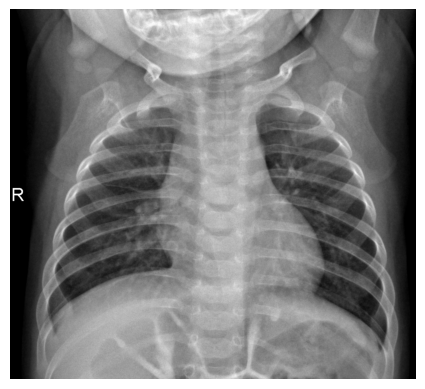

Classe : PNEUMONIA
Type des valeurs : uint8
Shape (dimensions)    : (1024, 1608, 3)
Type des valeurs      : uint8


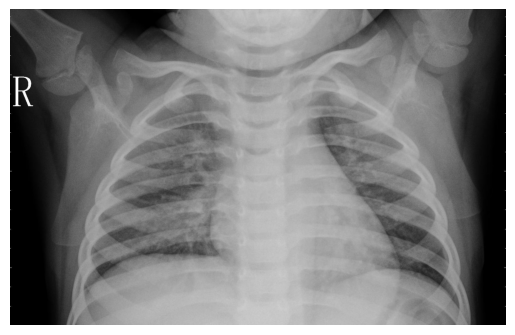

In [2]:
data_dir = "data/train"

classes = os.listdir(data_dir)
print("Classes disponibles :", classes)

for label in classes:
    path = os.path.join(data_dir, label)
    sample_img = random.choice(os.listdir(path))
    img = cv2.imread(os.path.join(path, sample_img), cv2.IMREAD_COLOR_RGB) #IMREAD_COLOR_RGB
    print(f"Classe : {label}")
    print(f"Type des valeurs : {img.dtype}")
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    # Inspection des métadonnées de l'image
    print(f"Shape (dimensions)    : {img.shape}")
    print(f"Type des valeurs      : {img.dtype}")
    plt.show()
    # Observer l'image sous forme de matrice
    #print(img)

## 🧹 3. Préparation des données

Nous utilisons un générateur de données (`ImageDataGenerator`) pour :

- redimensionner les images à la taille attendue par le modèle (224x224),
- effectuer une normalisation simple (rescale),
- créer un split automatique entre **données d'entraînement** et **données de validation** (20%).

Les images sont converties en **RGB**, car le modèle préentraîné attend 3 canaux d’entrée.


## 🧪 4. Preprocessing

Le prétraitement est effectué automatiquement par `ImageDataGenerator`, avec les étapes suivantes :

- redimensionnement des images (224x224),
- conversion en 3 canaux (RGB),
- effectuer une normalisation simple (rescale)
- normalisation des pixels (entre 0 et 1).

Les images sont converties en **RGB**, car le modèle préentraîné attend 3 canaux d’entrée.
Ces transformations sont nécessaires pour que les images soient compatibles avec le modèle DenseNet121.

Ces modifications sont faites pour les 3 dataset qui sont:
- test
- train
- val

In [3]:
# #transformer les label en int
# label_to_int = {"cat": 0, "dog": 1}

# def get_train_test(base_path: str, target_size=(64, 64)):
#     X = []  # liste pour stocker les images
#     y = []  # liste pour stocker les étiquettes correspondantes

#     # On parcourt les sous-dossiers du répertoire (un dossier par chiffre)
#     for label in sorted(os.listdir(base_path)):
#         # on ignore les fichiers qui ne sont pas des dossiers de chiffres
#         # if not label.isdigit():
#         #     continue
#         label_path = os.path.join(base_path, label)

#         # On parcourt chaque image du dossier
#         for file_name in os.listdir(label_path):
#             file_path = os.path.join(label_path, file_name)
#             # Lecture de l'image en niveaux de couleur
#             img = cv2.imread(file_path, cv2.IMREAD_COLOR_RGB)
#             if img is None:
#                 continue  # image illisible, on passe
            
#             img_resized = cv2.resize(img, target_size)
#             X.append(img_resized)           # on ajoute l'image à la liste
#             y.append(int(label_to_int[label]))    # on ajoute le label (ex: 0, 1, ..., 9)

#     # Conversion des listes en tableaux NumPy
#     X = np.array(X)
#     y = np.array(y)
#     return X, y

# X_train, y_train = get_train_test("data/pets/train")
# X_test, y_test = get_train_test("data/pets/test")

In [4]:

# Prétraitement commun
datagen = ImageDataGenerator(rescale=1./255)

# Générateur pour l'entraînement
train_generator = datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Générateur pour le test final
test_generator = datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Générateur pour la validation
val_generator = datagen.flow_from_directory(
    'data/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## 🧠 5. Modélisation

Nous utilisons le modèle **DenseNet121** disponible dans `Keras`, sans ses poids par défaut (`weights=None`), et nous le complétons avec une couche de classification binaire.

Ensuite, nous **chargeons les poids préentraînés de CheXNet**, disponibles au format `.h5`.  
Ces poids proviennent d’un entraînement sur un grand jeu de radios thoraciques (ChestX-ray14), et permettent d’adapter DenseNet121 au domaine médical.

Le modèle final est compilé pour une tâche de classification binaire (pneumonie vs normal).

## création du modèle

on reconstruit le même modele que cheXnet (pour charger les poids) car:
- Les poids .h5 sont associés à une architecture exacte
- on dois d’abord reconstruire cette même architecture (14 classes) pour les charger
- Puis, on peux couper/remplacer la dernière couche pour ton cas d’usage (binaire)

In [5]:
# Modèle basé sur DenseNet121
input_tensor = layers.Input(shape=(224, 224, 3))
model_densenet121 = DenseNet121(include_top=False, weights=None, input_tensor=input_tensor)

x = model_densenet121.output
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(14, activation='sigmoid')(x)  # 14 sorties comme CheXNet

#output = layers.Dense(1, activation='sigmoid')(x)  # Binaire : pneumonie ou non


model = models.Model(inputs= model_densenet121.input, outputs=output)

# Charger les poids de CheXNet (Keras)
model.load_weights("weights/CheXNet_Keras_0.3.0_weights.h5")

# Retirer la dernière couche et en ajouter une nouvelle
x = model.layers[-2].output  # on reprend la couche GlobalAveragePooling2D
output = layers.Dense(1, activation='sigmoid')(x)
final_model = models.Model(inputs=model.input, outputs=output)



# model = models.Sequential([
#     layers.Input(shape=(64, 64, 1)),
#     layers.Conv2D(128, (4, 4), activation='relu'),  # 1ère couche cachée avec 128 neurones
#     layers.Flatten(),                             # Passage vers Dense
#     #layers.Dense(64, activation='relu'),
#     layers.Dense(2, activation='softmax') # Couche de sortie : 2 classes (0 pourcat ou 1 pour dog), avec softmax qui permet d’obtenir une probabilité pour chaque classe
# ])

In [6]:
# Compiler
final_model.compile(
    optimizer='adam',                            # Méthode d’optimisation (descente de gradient)
    loss='binary_crossentropy',                  # Fonction de perte pour classification multi-classe avec étiquettes entières (ex : 0 à 9)
    metrics=['accuracy'])                        # On surveille l’exactitude pendant l'entraînement

In [7]:
# Résumé du modèle
final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

## 📈 6. Évaluation du modèle & Suivi avec MLflow

Nous entraînons le modèle sur les radios et évaluons ses performances sur l'ensemble de validation.

Dans une logique de **traçabilité expérimentale**, nous utilisons **MLflow** pour :

- enregistrer automatiquement les métriques d'entraînement (loss, accuracy, etc.),
- suivre les paramètres du modèle,
- sauvegarder l'historique des essais pour une future comparaison ou mise en production.

Ceci initie une approche MLOps pour le suivi reproductible de nos expériences.

- lancer mlflow: mlflow ui

In [ ]:
mlflow.set_experiment("CheXNet - Pneumonia Detection")

with mlflow.start_run():
    mlflow.tensorflow.autolog()

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)       # éviter le surapprentissage

    history = final_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[early_stop]
    )

    # Résultats finaux
    loss, acc = final_model.evaluate(val_generator)
    print(f"Validation Loss: {loss:.4f} | Accuracy: {acc:.4f}")

    # Log manuel si besoin
    mlflow.log_metric("final_accuracy", acc)
    mlflow.log_metric("final_loss", loss)


2025/05/22 09:00:15 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/05/22 09:00:15 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
c:\Users\rere0\Documents\python\CNN_diagnostic_pneumonie\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8999 - loss: 0.2451

163/163 ━━━━━━━━━━━━━━━━━━━━ 726s 4s/step - accuracy: 0.9002 - loss: 0.2444 - val_accuracy: 0.5625 - val_loss: 1.0794
Epoch 2/10
  5/163 ━━━━━━━━━━━━━━━━━━━━ 10:59 4s/step - accuracy: 0.9120 - loss: 0.1472